<a href="https://colab.research.google.com/github/giovannidispoto/machine-and-deep-learning-playground/blob/main/knowledge_distillation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Knowledge Distillation

In this notebook we will implement the knowledge distillation technique presented in the paper **Distilling the Knowledge in a Neural Network** by Hinton et Al., using a Teacher-Student Architecture.

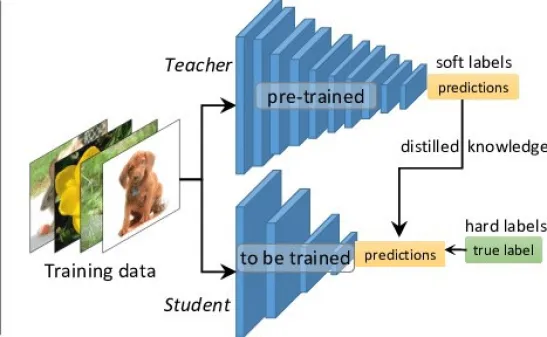

The main idea is to train a big complex network with a strong regularizer as Dropout and then distill the knowledge inside a simpler model that could be used in deployment.

In [23]:
import tensorflow as tf
import pandas as pd
import sklearn.preprocessing

In [24]:
tf.random.set_seed(1234)

In [25]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

In [26]:
label_binarizer = sklearn.preprocessing.LabelBinarizer()
label_binarizer.fit(range(10))
y_train = label_binarizer.transform(y_train)
y_test = label_binarizer.transform(y_test)

Teacher model

In [27]:
#Creating a CNN from scratch
teacher = tf.keras.Sequential()

start_f = 16
depth = 5
img_h = 32
img_w = 32
num_classes = 10

    
# Features extraction
for i in range(depth):
    if i == 0:
         input_shape = [img_h, img_w, 3]
    else:
         input_shape=[None]

        # Conv block: Conv2D -> Activation -> Conv2D -> Activation -> Pooling
    teacher.add(tf.keras.layers.Conv2D(filters=start_f, 
                                     kernel_size=(3, 3),
                                     strides=(1, 1),
                                     padding='same',
                                     input_shape=input_shape))
    teacher.add(tf.keras.layers.ReLU())
    teacher.add(tf.keras.layers.Conv2D(filters=start_f, 
                                     kernel_size=(3, 3),
                                     strides=(1, 1),
                                     padding='same'))
    teacher.add(tf.keras.layers.ReLU())                                
    teacher.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2,2)))

    start_f *= 2
    
# Classifier
teacher.add(tf.keras.layers.Flatten())
teacher.add(tf.keras.layers.Dense(units=512, activation='relu'))
teacher.add(tf.keras.layers.Dropout(0.3))
teacher.add(tf.keras.layers.Dense(units=num_classes))

In [28]:
teacher.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 32, 32, 16)        448       
_________________________________________________________________
re_lu_24 (ReLU)              (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 32, 32, 16)        2320      
_________________________________________________________________
re_lu_25 (ReLU)              (None, 32, 32, 16)        0         
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 16, 16, 32)        4640      
_________________________________________________________________
re_lu_26 (ReLU)              (None, 16, 16, 32)       

In [29]:
lr = 1e-4
teacher.compile(loss= tf.keras.losses.CategoricalCrossentropy(from_logits=True), optimizer=tf.keras.optimizers.Adam(lr), metrics=tf.keras.metrics.CategoricalAccuracy())
history_t = teacher.fit(x = x_train,
          y = y_train,
          batch_size=32,
          epochs=10, 
          validation_data=(x_test, y_test)
          )

Epoch 1/10
1563/1563 [==============================] - 27s 17ms/step - loss: 1.6111 - categorical_accuracy: 0.4113 - val_loss: 1.3495 - val_categorical_accuracy: 0.5204
Epoch 2/10
1563/1563 [==============================] - 26s 17ms/step - loss: 1.2927 - categorical_accuracy: 0.5362 - val_loss: 1.2236 - val_categorical_accuracy: 0.5681
Epoch 3/10
1563/1563 [==============================] - 26s 17ms/step - loss: 1.1208 - categorical_accuracy: 0.6007 - val_loss: 1.1081 - val_categorical_accuracy: 0.6100
Epoch 4/10
1563/1563 [==============================] - 25s 16ms/step - loss: 0.9928 - categorical_accuracy: 0.6480 - val_loss: 1.0432 - val_categorical_accuracy: 0.6292
Epoch 5/10
1563/1563 [==============================] - 25s 16ms/step - loss: 0.8860 - categorical_accuracy: 0.6890 - val_loss: 0.9911 - val_categorical_accuracy: 0.6562
Epoch 6/10
1563/1563 [==============================] - 25s 16ms/step - loss: 0.7804 - categorical_accuracy: 0.7280 - val_loss: 1.0108 - val_categoric

In [30]:
teacher.trainable = False

Here we are distilling by minimizing the difference between the Logits of the Teacher model and the Logits of the student model.
High temperature T-> +inf gives softer functions.

The distillation loss is meaused using the Kullback-Leibler divergence that meause the distance between two probability distribution (Student and Teacher). 

In [31]:
#Code from: https://keras.io/examples/vision/knowledge_distillation/
class Distiller(tf.keras.Model):
    def __init__(self, student, teacher):
        super(Distiller, self).__init__()
        self.teacher = teacher
        self.student = student

    def compile(
        self,
        optimizer,
        metrics,
        student_loss_fn,
        distillation_loss_fn,
        alpha=0.1,
        temperature=3,
    ):
        """ Configure the distiller.

        Args:
            optimizer: Keras optimizer for the student weights
            metrics: Keras metrics for evaluation
            student_loss_fn: Loss function of difference between student
                predictions and ground-truth
            distillation_loss_fn: Loss function of difference between soft
                student predictions and soft teacher predictions
            alpha: weight to student_loss_fn and 1-alpha to distillation_loss_fn
            temperature: Temperature for softening probability distributions.
                Larger temperature gives softer distributions.
        """
        super(Distiller, self).compile(optimizer=optimizer, metrics=metrics)
        self.student_loss_fn = student_loss_fn
        self.distillation_loss_fn = distillation_loss_fn
        self.alpha = alpha
        self.temperature = temperature

    def train_step(self, data):
        # Unpack data
        x, y = data

        # Forward pass of teacher
        teacher_predictions = self.teacher(x, training=False)

        with tf.GradientTape() as tape:
            # Forward pass of student
            student_predictions = self.student(x, training=True)

            # Compute losses
            student_loss = self.student_loss_fn(y, student_predictions)
            distillation_loss = self.distillation_loss_fn(
                tf.nn.softmax(teacher_predictions / self.temperature, axis=1),
                tf.nn.softmax(student_predictions / self.temperature, axis=1),
            )
            loss = self.alpha * student_loss + (1 - self.alpha) * distillation_loss

        # Compute gradients
        trainable_vars = self.student.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # Update the metrics configured in `compile()`.
        self.compiled_metrics.update_state(y, student_predictions)

        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update(
            {"student_loss": student_loss, "distillation_loss": distillation_loss}
        )
        return results

    def test_step(self, data):
        # Unpack the data
        x, y = data

        # Compute predictions
        y_prediction = self.student(x, training=False)

        # Calculate the loss
        student_loss = self.student_loss_fn(y, y_prediction)

        # Update the metrics.
        self.compiled_metrics.update_state(y, y_prediction)

        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update({"student_loss": student_loss})
        return results

Student model

In [32]:
#Creating a CNN from scratch
student = tf.keras.Sequential()

start_f = 8
depth = 2
img_h = 32
img_w = 32
num_classes = 10

    
# Features extraction
for i in range(depth):
    if i == 0:
         input_shape = [img_h, img_w, 3]
    else:
         input_shape=[None]

        # Conv block: Conv2D -> Activation -> Conv2D -> Activation -> Pooling
    student.add(tf.keras.layers.Conv2D(filters=start_f, 
                                     kernel_size=(3, 3),
                                     strides=(1, 1),
                                     padding='same',
                                     input_shape=input_shape))
    student.add(tf.keras.layers.ReLU())
    student.add(tf.keras.layers.Conv2D(filters=start_f, 
                                     kernel_size=(3, 3),
                                     strides=(1, 1),
                                     padding='same'))
    student.add(tf.keras.layers.ReLU())                                
    student.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2,2)))

    start_f *= 2
    
# Classifier
student.add(tf.keras.layers.Flatten())
student.add(tf.keras.layers.Dense(units=128, activation='relu'))
student.add(tf.keras.layers.Dense(units=num_classes))

In [33]:
student.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_34 (Conv2D)           (None, 32, 32, 8)         224       
_________________________________________________________________
re_lu_34 (ReLU)              (None, 32, 32, 8)         0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 32, 32, 8)         584       
_________________________________________________________________
re_lu_35 (ReLU)              (None, 32, 32, 8)         0         
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 16, 16, 8)         0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 16, 16, 16)        1168      
_________________________________________________________________
re_lu_36 (ReLU)              (None, 16, 16, 16)       

Here we create a copy of the student network in order to compare after the outcome of training with and without the teacher

In [34]:
student_copy = tf.keras.models.clone_model(student)

In [35]:
distiller = Distiller(student=student, teacher=teacher)

Fitting the student

In [36]:
distiller.compile(
    optimizer=tf.keras.optimizers.Adam(lr),
    metrics=[tf.keras.metrics.CategoricalAccuracy()],
    student_loss_fn=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    distillation_loss_fn=tf.keras.losses.KLDivergence(),
    alpha=0.1,
    temperature=10,
)

# Distill teacher to student
history_d = distiller.fit(x = x_train,
          y = y_train,
          batch_size=32,
          epochs=10, 
          validation_data=(x_test, y_test)
          )

Epoch 1/10
1563/1563 [==============================] - 17s 10ms/step - categorical_accuracy: 0.3060 - student_loss: 2.1648 - distillation_loss: 0.0869 - val_categorical_accuracy: 0.4058 - val_student_loss: 1.6866
Epoch 2/10
1563/1563 [==============================] - 16s 10ms/step - categorical_accuracy: 0.4516 - student_loss: 1.5590 - distillation_loss: 0.0598 - val_categorical_accuracy: 0.4745 - val_student_loss: 1.7725
Epoch 3/10
1563/1563 [==============================] - 16s 10ms/step - categorical_accuracy: 0.5069 - student_loss: 1.4048 - distillation_loss: 0.0519 - val_categorical_accuracy: 0.5080 - val_student_loss: 1.6417
Epoch 4/10
1563/1563 [==============================] - 16s 10ms/step - categorical_accuracy: 0.5439 - student_loss: 1.3048 - distillation_loss: 0.0471 - val_categorical_accuracy: 0.5364 - val_student_loss: 1.3814
Epoch 5/10
1563/1563 [==============================] - 16s 11ms/step - categorical_accuracy: 0.5714 - student_loss: 1.2275 - distillation_loss:

Now we train the very same model without the distillation in order to compare the performances between the previous one

In [37]:
lr = 1e-4
student_copy.compile(loss= tf.keras.losses.CategoricalCrossentropy(from_logits=True), optimizer=tf.keras.optimizers.Adam(lr), metrics=tf.keras.metrics.CategoricalAccuracy())
history_s = student_copy.fit(x = x_train,
          y = y_train,
          batch_size=32,
          epochs=10, 
          validation_data=(x_test, y_test)
          )

Epoch 1/10
1563/1563 [==============================] - 12s 7ms/step - loss: 2.2236 - categorical_accuracy: 0.2880 - val_loss: 1.7455 - val_categorical_accuracy: 0.3783
Epoch 2/10
1563/1563 [==============================] - 11s 7ms/step - loss: 1.6124 - categorical_accuracy: 0.4238 - val_loss: 1.5468 - val_categorical_accuracy: 0.4465
Epoch 3/10
1563/1563 [==============================] - 11s 7ms/step - loss: 1.4426 - categorical_accuracy: 0.4850 - val_loss: 1.4276 - val_categorical_accuracy: 0.4935
Epoch 4/10
1563/1563 [==============================] - 11s 7ms/step - loss: 1.3351 - categorical_accuracy: 0.5257 - val_loss: 1.3667 - val_categorical_accuracy: 0.5164
Epoch 5/10
1563/1563 [==============================] - 11s 7ms/step - loss: 1.2550 - categorical_accuracy: 0.5530 - val_loss: 1.3236 - val_categorical_accuracy: 0.5286
Epoch 6/10
1563/1563 [==============================] - 11s 7ms/step - loss: 1.1871 - categorical_accuracy: 0.5795 - val_loss: 1.2818 - val_categorical_acc

Comparison between student model trained from the teacher and model trained from scratch

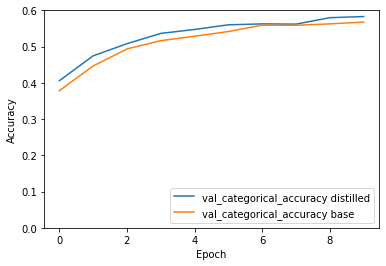

In [43]:
import matplotlib.pyplot as plt

plt.plot(history_d.history['val_categorical_accuracy'], label='val_categorical_accuracy distilled')
plt.plot(history_s.history['val_categorical_accuracy'], label = 'val_categorical_accuracy base')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 0.6])
plt.legend(loc='lower right')

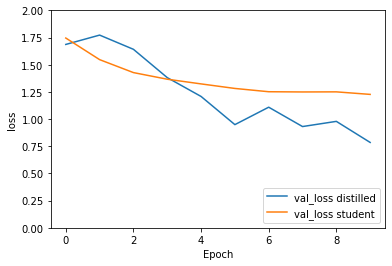

In [39]:
plt.plot(history_d.history['val_student_loss'], label='val_loss distilled')
plt.plot(history_s.history['val_loss'], label = 'val_loss base')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0,2])
plt.legend(loc='lower right')